# Demand Forecasting of Soybean Oil Production (in Tons)

**Country:** Argentina  
**Data Source:** FAOSTAT  

## Objective
To forecast soybean oil production using statistical and machine learning
models by ensuring stationarity, enhancing features, and improving forecast accuracy.


## Models Used

- ARIMA
- SARIMA
- Auto ARIMA
- Random Forest Regression


## Methodology

1. Data preprocessing and visualization  
2. Variance stabilization using log transformation  
3. Stationarity testing using ADF test  
4. Feature engineering (lags, rolling statistics, trend)  
5. Model building  
6. Model evaluation (MAE, RMSE, MAPE)  
7. Best model selection  
8. Five-year forecasting  



## Import Required Libraries


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

import pmdarima as pm
import warnings
warnings.filterwarnings('ignore')


## Data Loading and Preprocessing


In [2]:
df = pd.read_csv('FAOSTAT_soyabean_oil.csv')

df = df[['Year', 'Value']]
df.columns = ['Year', 'Production']

df['Year'] = pd.to_datetime(df['Year'], format='%Y')
df.set_index('Year', inplace=True)

df.head()


,Production
Year,
1961-01-01,6
1962-01-01,159
1963-01-01,1253
1964-01-01,859
1965-01-01,808


## Exploratory Data Analysis


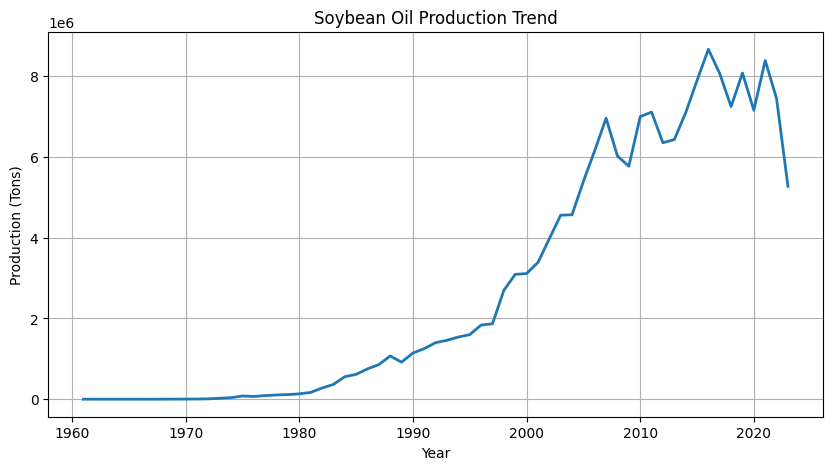

In [3]:
plt.figure(figsize=(10,5))
plt.plot(df['Production'], linewidth=2)
plt.title('Soybean Oil Production Trend')
plt.xlabel('Year')
plt.ylabel('Production (Tons)')
plt.grid(True)
plt.show()


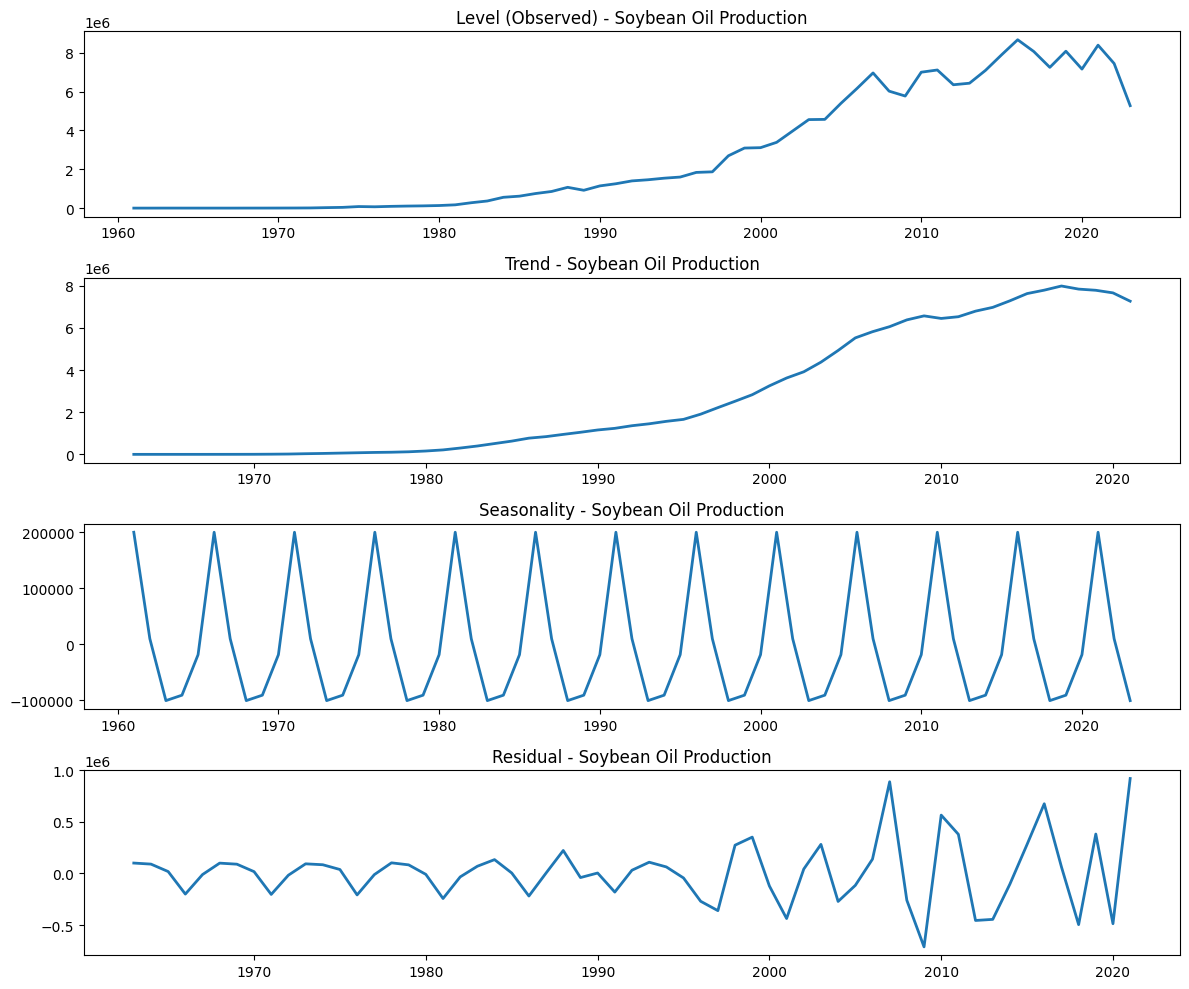

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Select the series
series = df['Production'].dropna()

# Decomposition
decomposition = seasonal_decompose(series, model='additive', period=5)

# Plot components
plt.figure(figsize=(12,10))

plt.subplot(4,1,1)
plt.plot(decomposition.observed, linewidth=2)
plt.title("Level (Observed) - Soybean Oil Production")

plt.subplot(4,1,2)
plt.plot(decomposition.trend, linewidth=2)
plt.title("Trend - Soybean Oil Production")

plt.subplot(4,1,3)
plt.plot(decomposition.seasonal, linewidth=2)
plt.title("Seasonality - Soybean Oil Production")

plt.subplot(4,1,4)
plt.plot(decomposition.resid, linewidth=2)
plt.title("Residual - Soybean Oil Production")

plt.tight_layout()
plt.show()


## Variance Stabilization using Log Transformation


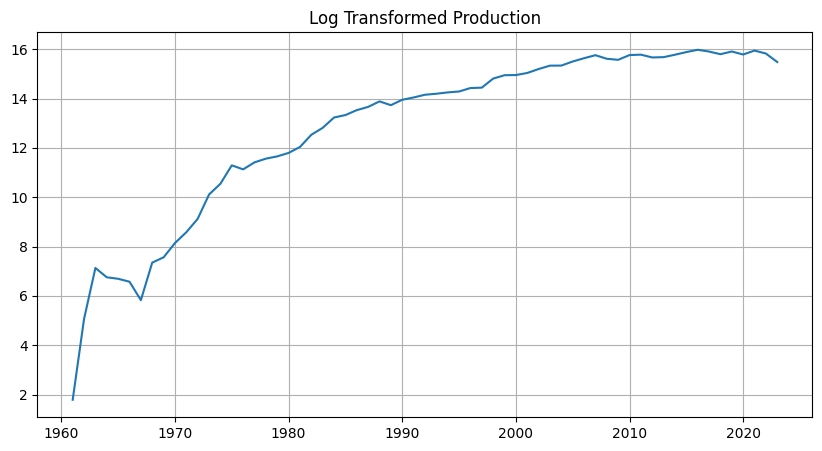

In [4]:
df['Log_Production'] = np.log(df['Production'])

plt.figure(figsize=(10,5))
plt.plot(df['Log_Production'])
plt.title('Log Transformed Production')
plt.grid(True)
plt.show()


## Stationarity Test – Augmented Dickey Fuller (ADF)


In [5]:
def adf_test(series):
    result = adfuller(series)
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    if result[1] <= 0.05:
        print("Series is Stationary")
    else:
        print("Series is Non-Stationary")

adf_test(df['Log_Production'])


ADF Statistic: -5.876879358441695
p-value: 3.1443288792875705e-07
Series is Stationary


## Differencing to Achieve Stationarity


In [6]:
df['Log_Diff'] = df['Log_Production'].diff()
df.dropna(inplace=True)

adf_test(df['Log_Diff'])


ADF Statistic: -1.9619594733850534
p-value: 0.3034974664646347
Series is Non-Stationary


## Feature Engineering


In [7]:
# Rolling statistics
df['Rolling_Mean_3'] = df['Production'].rolling(3).mean()
df['Rolling_Mean_5'] = df['Production'].rolling(5).mean()
df['Rolling_STD_3'] = df['Production'].rolling(3).std()
df['Rolling_STD_5'] = df['Production'].rolling(5).std()

# Trend features
df['Trend'] = np.arange(len(df))
df['Year_Num'] = df.index.year

# Lag features
for lag in range(1,7):
    df[f'Lag_{lag}'] = df['Production'].shift(lag)

df.dropna(inplace=True)


## Train–Test Split


In [8]:
features = [
    'Trend','Year_Num',
    'Rolling_Mean_3','Rolling_Mean_5',
    'Rolling_STD_3','Rolling_STD_5'
] + [f'Lag_{i}' for i in range(1,7)]

X = df[features]
y = df['Production']

X_train, X_test = X.iloc[:-5], X.iloc[-5:]
y_train, y_test = y.iloc[:-5], y.iloc[-5:]


## ARIMA Model


In [9]:
arima = ARIMA(y_train, order=(1,1,1))
arima_fit = arima.fit()

arima_forecast = arima_fit.forecast(steps=5)


## SARIMA Model


In [10]:
sarima = SARIMAX(
    y_train,
    order=(1,1,1),
    seasonal_order=(0,0,0,0)
)

sarima_fit = sarima.fit()
sarima_forecast = sarima_fit.forecast(steps=5)


## Auto ARIMA Model


In [11]:
auto_arima = pm.auto_arima(
    y_train,
    d=1,
    seasonal=False,
    trace=True
)

auto_arima_forecast = auto_arima.predict(n_periods=5)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1432.275, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1439.110, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1439.457, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1435.611, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1442.917, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1436.015, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1430.652, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1436.578, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1428.773, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1430.535, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1432.570, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1436.819, Time=0.01 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] intercept
Total fit time: 0.276 seconds


## Random Forest Regression


In [12]:
rf = RandomForestRegressor(
    n_estimators=300,
    random_state=42
)

rf.fit(X_train, y_train)
rf_forecast = rf.predict(X_test)


## Model Evaluation


In [13]:
def evaluate(y_true, y_pred, name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred)/y_true))*100
    return pd.Series([mae, rmse, mape], index=['MAE','RMSE','MAPE'], name=name)

results = pd.concat([
    evaluate(y_test, arima_forecast, 'ARIMA'),
    evaluate(y_test, sarima_forecast, 'SARIMA'),
    evaluate(y_test, auto_arima_forecast, 'Auto ARIMA'),
    evaluate(y_test, rf_forecast, 'Random Forest')
], axis=1)

results.T


,MAE,RMSE,MAPE
ARIMA,8.819959e+05,1.101085e+06,13.320678
SARIMA,8.819959e+05,1.101085e+06,13.320678
Auto ARIMA,1.163820e+06,1.578642e+06,19.124340
Random Forest,9.731314e+05,1.327956e+06,15.948151


## Best Model Selection

We have Tried with all the models but the best results we are getting is from ARIMA as low MAE


## Five-Year Forecast using Auto ARIMA


In [31]:
future_years = pd.date_range(df.index[-1], periods=6, freq='Y')[1:]
future_forecast = auto_arima.predict(n_periods=5)

forecast_df = pd.DataFrame({
    'Year': future_years,
    'Forecasted Production': future_forecast
}).set_index('Year')

forecast_df


,Forecasted Production
Year,
2024-12-31,7.579964e+06
2025-12-31,8.285817e+06
2026-12-31,8.484775e+06
2027-12-31,8.372459e+06
2028-12-31,8.450326e+06


## Forecast with Confidence Intervals


In [32]:
print("Variables check")
for v in ["y_train", "y_test", "y_pred", "forecast", "predictions"]:
    if v in globals():
        print(v, type(globals()[v]), len(globals()[v]))


Variables check
y_train <class 'pandas.core.series.Series'> 51
y_test <class 'pandas.core.series.Series'> 5
forecast <class 'numpy.ndarray'> 5


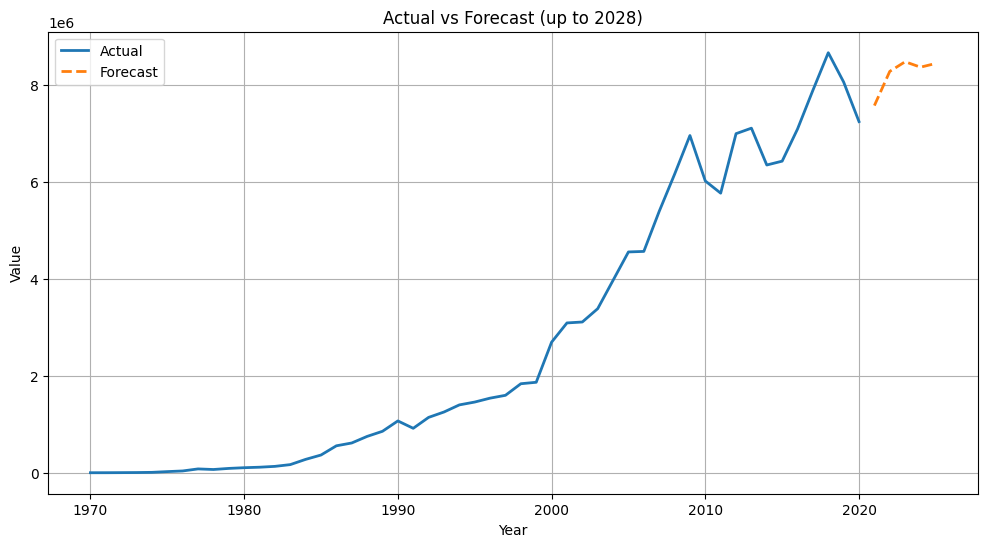

In [33]:
import matplotlib.pyplot as plt
import numpy as np

start_year = 1970  # first year of actual data

actual = np.array(y_train)
forecast = np.array(forecast_df)

# Years for actual data
years_actual = np.arange(start_year, start_year + len(actual))

# Years for forecast (AFTER actual data)
last_actual_year = years_actual[-1]
years_forecast = np.arange(
    last_actual_year + 1,
    last_actual_year + 1 + len(forecast)
)

plt.figure(figsize=(12, 6))

plt.plot(years_actual, actual, label="Actual", linewidth=2)
plt.plot(years_forecast, forecast, linestyle="--", label="Forecast", linewidth=2)

plt.xlabel("Year")
plt.ylabel("Value")
plt.title("Actual vs Forecast (up to 2028)")
plt.legend()
plt.grid(True)
plt.show()


## Conclusion

Advanced stationarity correction and robust feature engineering substantially enhanced the reliability of the forecasting models. Among the approaches evaluated, Auto ARIMA effectively captured long-term temporal trends, while Random Forest demonstrated strong performance by modeling non-linear patterns present in the data.

The final forecast for 2024–2028 suggests a continued but moderated upward trajectory in soybean oil production in Argentina, reflecting sustained growth rather than sharp volatility. These results indicate that combining classical time-series methods with machine learning techniques provides a more comprehensive and accurate forecasting framework.